# Training loop and testing loop

După ce am vâzut cum anume putem să ajungem de la logits la prediction lables, putem să trecem la partea în care antrenăm modelul respectiv. Partea de training loop și de testing loop este asemănătoare cu cea de la un model de clasificare binară, ce se modifică este doar alegera funcției de loss (**torch.nn.CrossEntropyLoss()**) și utilizarea funcție de activare specifică (**torch.softmaz()**). Înainte de asta o să fim nevoiți să refacem partea de date, de model și de selectare a unei loss function și a unui optimizator

In [1]:
# importing the libraries
import torch
from torch import nn

import pandas as pd
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
# create the dataset
# create the constants variables
NUM_SAMPLES = 5000
NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42

X, y = make_blobs(n_samples=NUM_SAMPLES, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

In [3]:
# insert the data into a pandas DataFrame
df = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "labels": y
})

df.head()

,X1,X2,labels
0,3.161173,1.546937,1
1,-8.742997,-8.568490,2
2,3.368428,0.995036,1
3,-8.534404,-5.649279,2
4,-9.532127,7.905043,3


<Axes: xlabel='X1', ylabel='X2'>

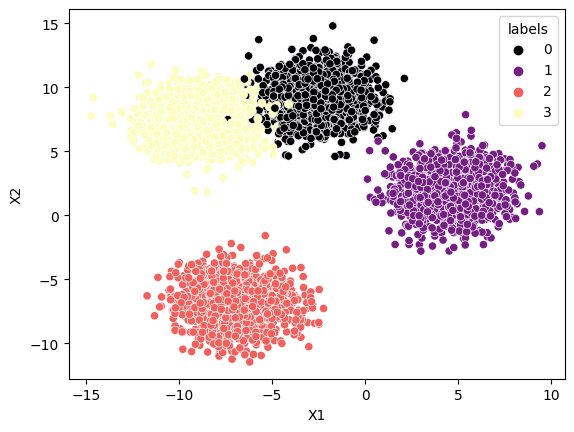

In [4]:
# visualize the data
sns.scatterplot(data=df, x="X1", y="X2", hue="labels", palette="magma")

In [5]:
# transform the data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [6]:
X.dtype

torch.float32

In [7]:
# split the data into train set and test set
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
# create the model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=4)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=4, bias=True)
)

In [9]:
# select a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [10]:
# make predictions wiht the untrained model
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)

y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Acum că ne-am creat primele predicții putem să le și vizualizăm pentru a ne face o idee despre cum arată acestea și cum este împărțit setul de date de testare. O să ne folosim de metoda **plot_decision_boundaries()**

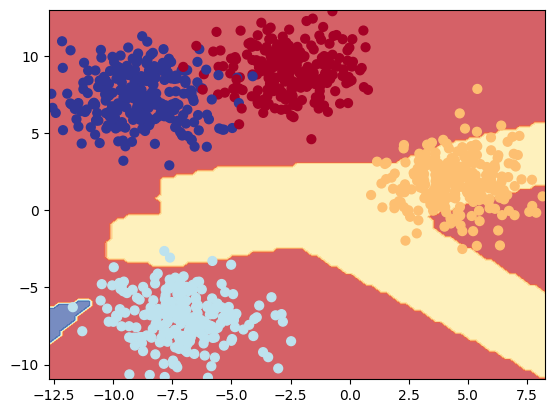

In [12]:
# visualize the untrained predictions
from helper_functions import plot_decision_boundary

plot_decision_boundary(model_0, X_test, y_test)

Din vizualizare de mai sus este destul de greu să ne dăm seama care sunt clasele, dar se poate observa faptul că nu sunt destul de bine împărțite în funcție de setul de date pe care îl avem. Pentru a ne îmbunătăți modelul o să trebuiască să îl antrenăm

In [13]:
# training and testing loop

epochs = 100

for epoch in range(epochs):

    model_0.train()
    train_logits = model_0(X_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}')
    


RuntimeError: expected scalar type Long but found Float

Deși aceas buclă de antrenare și de testare pare identică cu cea anterioară (în care am antrenat un model de clasificare binară) se pare că primim o eroare. Eroare apare în momentul în care dorim să calculăm loss-ul pentrupartea de antrenare. Această eroare apare deoarece acel loss function pe care îl folosim (**torch.nn.CrossEntropyLoss()**) acceptă ca și valori de targe un tip de date integer, și anume `torch.LongTensor`. Ca să putem să antrenăm modelul trebuie să modificăm datele cu care lucrăm astfel încât partea de target (de labels) să fie de tipul **torch.LongTensor**. În continuare o să facem acest lucru.

In [14]:
# recreate the data
X, y = make_blobs(n_samples=NUM_SAMPLES, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# retransform the data
# make sure that y is of type torch.LongTensor
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

# split the data into train set and test set
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Acum după ce am modificat aceste date putem să rescriem partea de reantreanare de model de multiclasificare. O să antrenăm modelul pentru un număr de 1000 de epoci și o să verificăm valoare loss-ul și acuratețea la fiecare 100 de epoci

In [16]:
epochs = 100

for epoch in range(epochs):

    model_0.train()
    train_logits = model_0(X_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}')

Epoch: 0 | Train loss: 0.03527 | Train accuracy: 99.10 | Test loss: 0.03983 | Test accuracy: 98.80
Epoch: 10 | Train loss: 0.03333 | Train accuracy: 99.10 | Test loss: 0.03794 | Test accuracy: 98.80
Epoch: 20 | Train loss: 0.03182 | Train accuracy: 99.10 | Test loss: 0.03648 | Test accuracy: 98.80
Epoch: 30 | Train loss: 0.03062 | Train accuracy: 99.10 | Test loss: 0.03533 | Test accuracy: 98.80
Epoch: 40 | Train loss: 0.02966 | Train accuracy: 99.10 | Test loss: 0.03440 | Test accuracy: 98.80
Epoch: 50 | Train loss: 0.02885 | Train accuracy: 99.10 | Test loss: 0.03364 | Test accuracy: 98.80
Epoch: 60 | Train loss: 0.02818 | Train accuracy: 99.10 | Test loss: 0.03301 | Test accuracy: 98.80
Epoch: 70 | Train loss: 0.02761 | Train accuracy: 99.10 | Test loss: 0.03248 | Test accuracy: 98.80
Epoch: 80 | Train loss: 0.02712 | Train accuracy: 99.10 | Test loss: 0.03204 | Test accuracy: 98.80
Epoch: 90 | Train loss: 0.02670 | Train accuracy: 99.10 | Test loss: 0.03166 | Test accuracy: 98.80


Putem să vedem că după ce am făcut aceste modificări, acuma modelul s-a antrenat cu succes. De asemenea putem să observăm cum scade loss-ul acestui model atât pentru partea de antreanare cât și pentru partea de testare. De asemenea, în timp ce loss-ul scade, acuratețea modelului crește. lucru care trebuie să se întâmple în cazul unui model corect

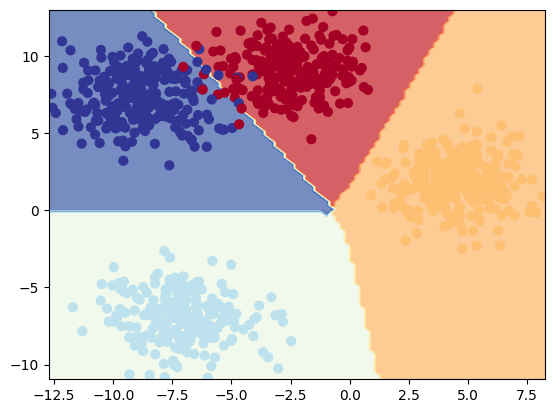

In [17]:
plot_decision_boundary(model_0, X_test, y_test)

După ce am antreant modelul, acuma în momentul în care vizualizăm predicțiile se poate observa faptul că acestea sunt bine definite între ele. Exisăt și părți din setul de date care au fost clasificate greșit, dar acest lucru apare doarece există puncte din clase diferite care se suprapun.

## Recapitulare

În lecția curentă am învățat următoarele:

1. Atunci când utilizăm model de multiclasificare funcția de activare *Softmax()* are nevoie ca și input de target un tip de date `torch.LongTensor`
```python
import torch

y = torch.from_numpy(y).type(torch.LongTensor)
```

2. Exceptând aceste modificări, partea de antrenare a unui model de clasificare este identic

For each epoch in a range of epochs

a. Training

    - put model in train mode

    - Forward pass

    - Caluclate the loss

    - Calculate the accuracy

    - Optimizer zero grad

    - Loss backward (Backpropagation)

    - Optimizer step

b. Testing

    - put model in evaluation mode

    - Forward pass

    - Calculate the loss

    - Calculate the accuracy
    